# JSON vs orjson – Energy Consumption Analysis

Compares 30 repeated trials of `json.loads` vs `orjson.loads` measured with
EnergiBridge.  Key metrics: **duration**, **CPU energy**, **CORE0 energy**,
and **average CPU power**.

### Column selection

Each CSV contains 42 columns.  Since the focus of this course is
**energy consumption**, we keep only the energy-relevant columns:

| Kept | Reason |
|------|--------|
| `Delta` | Sampling interval (ms) |
| `Time` | Unix timestamp (ms) — used to compute duration |
| `CPU_ENERGY (J)` | Total CPU-package energy counter (RAPL) |
| `CORE0_ENERGY (J)` | Single-core energy counter (RAPL) |

All other columns (16× per-core frequency, 16× per-core usage,
CORE0 frequency / voltage, and all memory / swap columns) are
**dropped** — they are system-state telemetry, not energy measurements.

In [38]:
import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd()))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.energy_metrics import (
    load_all_runs, remove_outliers, compare_groups, load_run,
)

sns.set_theme(style="whitegrid", context="notebook")
FIGURES = pathlib.Path("figures")
FIGURES.mkdir(exist_ok=True)

## 1. Load and summarise all 30 runs per library

In [39]:
DATA_ROOT = pathlib.Path("..") 

json_df_5 = load_all_runs(DATA_ROOT / "json_energy")
json_df_5["library"] = "json"

orjson_df_5 = load_all_runs(DATA_ROOT / "orjson_energy")
orjson_df_5["library"] = "orjson"



all_df_5 = pd.concat([json_df_5, orjson_df_5], ignore_index=True)
print(f"Loaded {len(json_df_5)} json runs, {len(orjson_df_5)} orjson runs")
all_df_5.describe()

Loaded 30 json runs, 30 orjson runs


,duration_s,cpu_energy_j,core0_energy_j,avg_cpu_power_w
count,60.000000,60.000000,60.000000,60.000000
mean,22.896083,661.697170,49172.756831,28.921687
std,1.153734,75.133136,20172.323459,3.095003
min,20.832000,598.658707,12069.892899,26.655343
25%,22.033000,619.663311,34073.768635,26.896151
50%,23.037500,636.142899,49725.589020,28.220832
75%,23.437000,655.297371,60724.663128,28.797203
max,26.039000,951.724457,107465.230377,39.236490


## 2. Outlier removal (IQR × 1.5)

Outliers are detected **per library** (json / orjson) using the
**Interquartile Range (IQR)** method on each of the three core metrics:
`duration_s`, `cpu_energy_j`, and `core0_energy_j`.

For each metric the 25th percentile (Q1) and 75th percentile (Q3) are
computed, and the IQR = Q3 − Q1.  Any run whose value falls outside
**[Q1 − 1.5 × IQR,  Q3 + 1.5 × IQR]** is flagged as an outlier.
A run is **removed** if it is an outlier in **any** of the three metrics.

In [40]:
clean_frames, outlier_frames = [], []
for lib in ("json", "orjson"):
    subset = all_df_5[all_df_5["library"] == lib].copy()
    clean, outliers = remove_outliers(subset)
    clean_frames.append(clean)
    outlier_frames.append(outliers)
    n_out = len(outliers)
    print(f"{lib}: kept {len(clean)}/{len(subset)} runs  ({n_out} outlier{'s' if n_out != 1 else ''})")
    if n_out:
        print(f"  removed: {outliers['file'].tolist()}")

clean_df = pd.concat(clean_frames, ignore_index=True)
outlier_df = pd.concat(outlier_frames, ignore_index=True)
clean_df.head()

json: kept 24/30 runs  (6 outliers)
  removed: ['energy_json_run05.csv', 'energy_json_run06.csv', 'energy_json_run07.csv', 'energy_json_run08.csv', 'energy_json_run09.csv', 'energy_json_run19.csv']
orjson: kept 25/30 runs  (5 outliers)
  removed: ['energy_orjson_run05.csv', 'energy_orjson_run06.csv', 'energy_orjson_run07.csv', 'energy_orjson_run08.csv', 'energy_orjson_run23.csv']


,file,duration_s,cpu_energy_j,core0_energy_j,avg_cpu_power_w,library
0,energy_json_run01.csv,24.241,656.920120,18649.302216,27.099547,json
1,energy_json_run02.csv,24.239,652.784332,22742.944534,26.931158,json
2,energy_json_run03.csv,24.238,649.154083,34689.931122,26.782494,json
3,energy_json_run04.csv,24.039,646.579422,49480.791077,26.897101,json
4,energy_json_run10.csv,24.039,654.100189,55654.576324,27.209958,json


## 3. Statistical tests (Shapiro → Welch / Mann-Whitney)

Our goal is to answer: **does `orjson` actually consume less energy
(or run faster) than `json`, or are the differences we see in the
box-plots just random noise from run-to-run variation?**  With only
~25 samples per group after outlier removal, eyeballing the plots is
not reliable — we need a p-value to be confident.

**Why Shapiro–Wilk first?**  Energy measurements from repeated runs
are not guaranteed to be normally distributed — background OS activity,
thermal throttling, or swap pressure can skew individual runs.  We run
Shapiro–Wilk on each group to check, because the validity of the next
test depends on it: a parametric test on non-normal data would give
misleading p-values.

**Why Welch's t-test?**  When both groups *are* normal, Welch's t-test
is the strongest option for our setup: two independent groups (json vs
orjson) that may have different variances (e.g. orjson might be more
consistent than json).  It directly tests whether the mean energy /
duration differs between the two libraries.

**Why Mann–Whitney U?**  When Shapiro–Wilk rejects normality for either
group, we cannot trust the t-test.  Mann–Whitney makes no distributional
assumptions, so it remains valid even when our energy data is skewed —
which, as the results below show, happens for most of our metrics.

In [41]:
METRICS = ["duration_s", "cpu_energy_j", "core0_energy_j", "avg_cpu_power_w"]

json_clean = clean_df[clean_df["library"] == "json"]
orjson_clean = clean_df[clean_df["library"] == "orjson"]

results = {}
for m in METRICS:
    res = compare_groups(json_clean[m].values, orjson_clean[m].values)
    results[m] = res
    sig = "***" if res["p_value"] < 0.001 else "**" if res["p_value"] < 0.01 else "*" if res["p_value"] < 0.05 else "ns"
    print(
        f"{m:20s}  {res['test']:16s}  p={res['p_value']:.4e} {sig}  "
        f"{res['effect_name']}={res['effect_size']:+.3f}  "
        f"json={res['json_mean']:.4f}±{res['json_std']:.4f}  "
        f"orjson={res['orjson_mean']:.4f}±{res['orjson_std']:.4f}"
    )

results_df = pd.DataFrame(results).T
results_df

duration_s            Mann-Whitney U    p=2.3459e-06 ***  Cliff's delta=+0.788  json=23.4710±0.4826  orjson=22.2028±0.8748
cpu_energy_j          Mann-Whitney U    p=5.0286e-01 ns  Cliff's delta=-0.113  json=631.1983±14.1573  orjson=635.6914±23.9769
core0_energy_j        Welch t-test      p=8.0878e-08 ***  Cohen's d=-1.864  json=32796.7993±13770.0592  orjson=55173.6559±10020.1892
avg_cpu_power_w       Mann-Whitney U    p=2.0984e-09 ***  Cliff's delta=-1.000  json=26.8922±0.1655  orjson=28.6377±0.5257


,test,statistic,p_value,shapiro_p_json,shapiro_p_orjson,both_normal,effect_size,effect_name,json_mean,json_std,orjson_mean,orjson_std
duration_s,Mann-Whitney U,536.5,0.000002,0.001388,0.070408,False,0.788333,Cliff's delta,23.470958,0.482587,22.20284,0.874822
cpu_energy_j,Mann-Whitney U,266.0,0.502858,0.014307,0.443649,False,-0.113333,Cliff's delta,631.198323,14.157296,635.691428,23.976857
core0_energy_j,Welch t-test,-6.48216,0.0,0.156715,0.971282,True,-1.864348,Cohen's d,32796.799321,13770.059219,55173.655909,10020.189246
avg_cpu_power_w,Mann-Whitney U,0.0,0.0,0.001584,0.000714,False,-1.0,Cliff's delta,26.892194,0.16551,28.637679,0.525742


## 4. Distribution plots (box + strip)

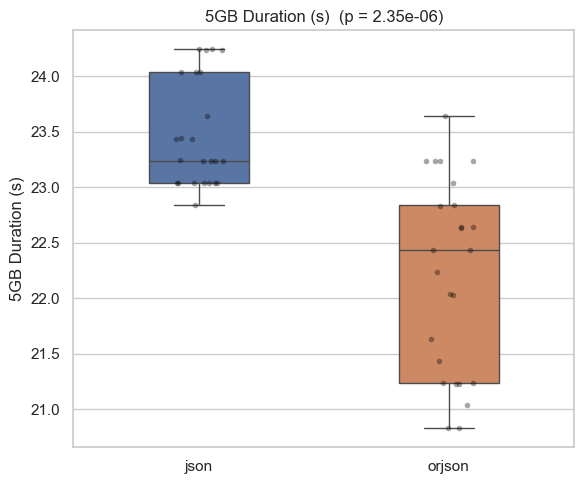

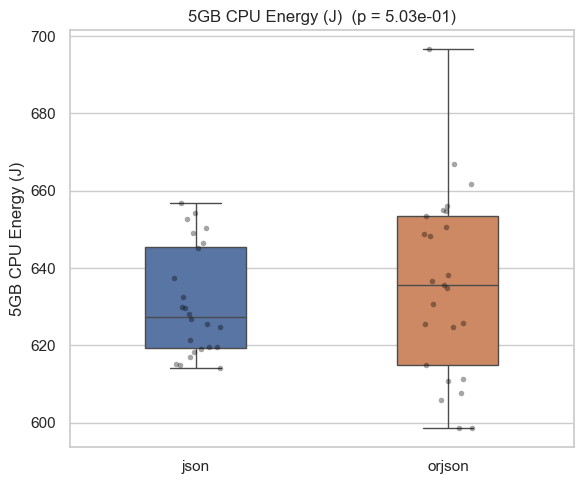

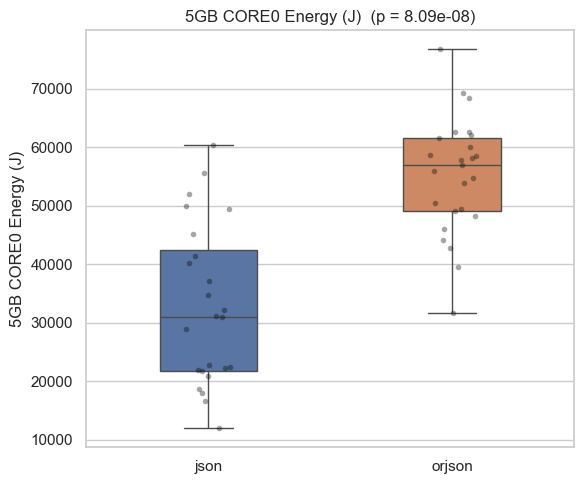

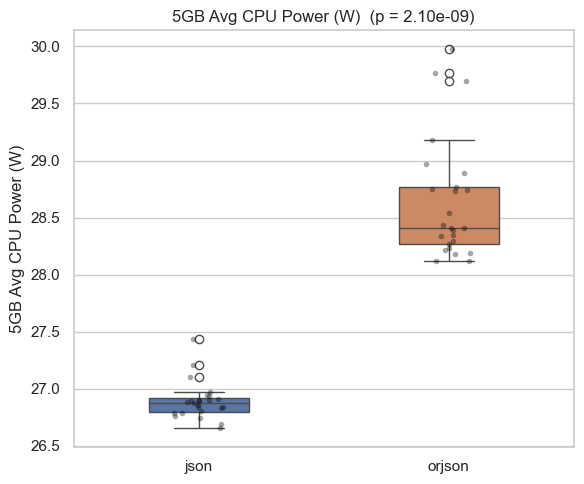

In [42]:
LABELS = {
    "duration_s": "5GB Duration (s)",
    "cpu_energy_j": "5GB CPU Energy (J)",
    "core0_energy_j": "5GB CORE0 Energy (J)",
    "avg_cpu_power_w": "5GB Avg CPU Power (W)",
}

for metric in METRICS:
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.boxplot(data=clean_df, x="library", y=metric, hue="library", ax=ax, width=0.4,
                palette={"json": "#4C72B0", "orjson": "#DD8452"}, legend=False)
    sns.stripplot(data=clean_df, x="library", y=metric, ax=ax,
                  color="black", alpha=0.35, size=4, jitter=True)
    p = results[metric]["p_value"]
    ax.set_title(f"{LABELS[metric]}  (p = {p:.2e})")
    ax.set_xlabel("")
    ax.set_ylabel(LABELS[metric])
    fig.tight_layout()
    fig.savefig(FIGURES / f"{metric}.png", dpi=150, bbox_inches="tight")
    plt.show()

## 5. Energy vs Duration scatter

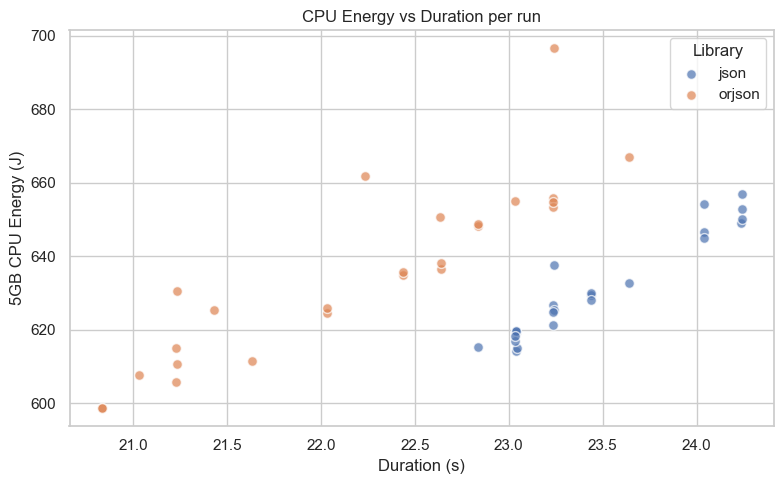

In [43]:
fig, ax = plt.subplots(figsize=(8, 5))
colors = {"json": "#4C72B0", "orjson": "#DD8452"}
for lib, grp in clean_df.groupby("library"):
    ax.scatter(grp["duration_s"], grp["cpu_energy_j"],
               label=lib, color=colors[lib], s=50, alpha=0.7, edgecolors="white")
ax.set_xlabel("Duration (s)")
ax.set_ylabel("5GB CPU Energy (J)")
ax.set_title("CPU Energy vs Duration per run")
ax.legend(title="Library")
fig.tight_layout()
fig.savefig(FIGURES / "energy_vs_duration.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Run 30 time-series (CPU Energy and CORE0 Energy over time)

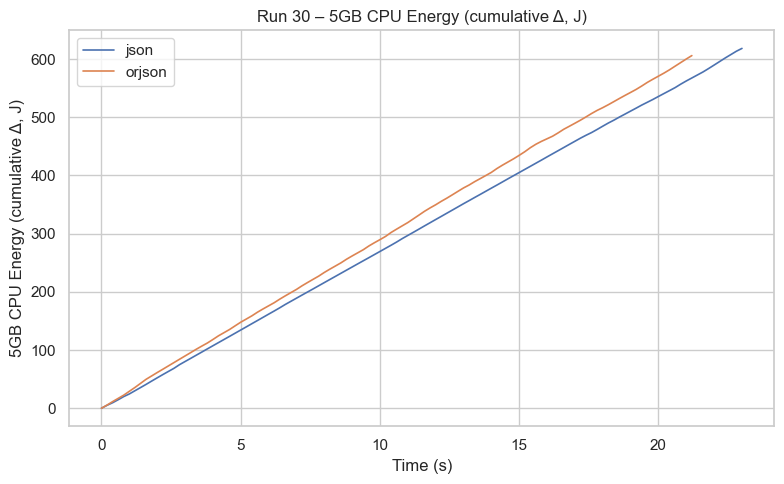

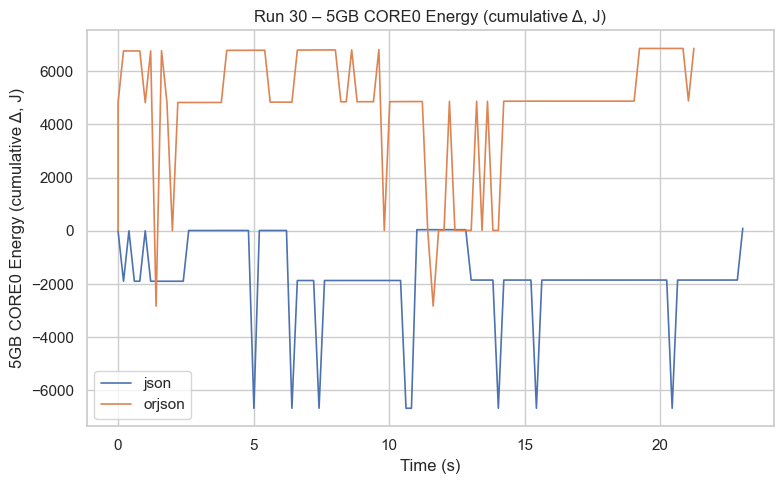

In [44]:
json_r30 = load_run(DATA_ROOT / "json_energy" / "energy_json_run30.csv")
orjson_r30 = load_run(DATA_ROOT / "orjson_energy" / "energy_orjson_run30.csv")

def normalise(df):
    """Zero-base time and energy columns for easier comparison."""
    d = df.copy()
    d["time_s"] = (d["Time"] - d["Time"].iloc[0]) / 1000.0
    d["cpu_energy_delta"] = d["CPU_ENERGY (J)"] - d["CPU_ENERGY (J)"].iloc[0]
    d["core0_energy_delta"] = d["CORE0_ENERGY (J)"] - d["CORE0_ENERGY (J)"].iloc[0]
    return d

json_r30_n = normalise(json_r30)
orjson_r30_n = normalise(orjson_r30)

TIMESERIES = [
    ("cpu_energy_delta", "5GB CPU Energy (cumulative Δ, J)", "run30_cpu_energy"),
    ("core0_energy_delta", "5GB CORE0 Energy (cumulative Δ, J)", "run30_core0_energy"),
]

for col, title, fname in TIMESERIES:
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(json_r30_n["time_s"], json_r30_n[col], label="json", color="#4C72B0", linewidth=1.2)
    ax.plot(orjson_r30_n["time_s"], orjson_r30_n[col], label="orjson", color="#DD8452", linewidth=1.2)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(title)
    ax.set_title(f"Run 30 – {title}")
    ax.legend()
    fig.tight_layout()
    fig.savefig(FIGURES / f"{fname}.png", dpi=150, bbox_inches="tight")
    plt.show()

---
## 7. 1 GB file — Load and summarise all 30 runs per library

Same pipeline as sections 1–6, applied to the **1 GB** dataset
(`json_energy_1g` / `orjson_energy_1g`).

In [45]:
json_df_1 = load_all_runs(DATA_ROOT / "json_energy_1g")
json_df_1["library"] = "json"

orjson_df_1 = load_all_runs(DATA_ROOT / "orjson_energy_1g")
orjson_df_1["library"] = "orjson"

all_df_1 = pd.concat([json_df_1, orjson_df_1], ignore_index=True)
print(f"Loaded {len(json_df_1)} json runs, {len(orjson_df_1)} orjson runs")
all_df_1.describe()

Loaded 30 json runs, 30 orjson runs


,duration_s,cpu_energy_j,core0_energy_j,avg_cpu_power_w
count,60.000000,60.000000,60.000000,60.000000
mean,4.006150,108.279328,12629.886841,27.067166
std,0.630169,16.151186,7861.111535,0.487436
min,3.204000,87.057068,2382.510147,26.390978
25%,3.405000,92.637787,7946.138275,26.730634
50%,4.006500,110.597855,11161.006401,26.996238
75%,4.607000,123.313526,16117.077278,27.274296
max,5.008000,140.409836,36855.155273,29.254764


## 8. 1 GB — Outlier removal (IQR × 1.5)

In [46]:
clean_frames_1, outlier_frames_1 = [], []
for lib in ("json", "orjson"):
    subset = all_df_1[all_df_1["library"] == lib].copy()
    clean, outliers = remove_outliers(subset)
    clean_frames_1.append(clean)
    outlier_frames_1.append(outliers)
    n_out = len(outliers)
    print(f"{lib}: kept {len(clean)}/{len(subset)} runs  ({n_out} outlier{'s' if n_out != 1 else ''})")
    if n_out:
        print(f"  removed: {outliers['file'].tolist()}")

clean_df_1 = pd.concat(clean_frames_1, ignore_index=True)
outlier_df_1 = pd.concat(outlier_frames_1, ignore_index=True)
clean_df_1.head()

json: kept 25/30 runs  (5 outliers)
  removed: ['energy_json_run01.csv', 'energy_json_run03.csv', 'energy_json_run04.csv', 'energy_json_run07.csv', 'energy_json_run25.csv']
orjson: kept 25/30 runs  (5 outliers)
  removed: ['energy_orjson_run05.csv', 'energy_orjson_run15.csv', 'energy_orjson_run19.csv', 'energy_orjson_run23.csv', 'energy_orjson_run26.csv']


,file,duration_s,cpu_energy_j,core0_energy_j,avg_cpu_power_w,library
0,energy_json_run02.csv,4.606,123.079895,4094.945450,26.721645,json
1,energy_json_run05.csv,4.608,123.408249,21293.119614,26.781304,json
2,energy_json_run06.csv,4.606,122.790878,15731.594009,26.658897,json
3,energy_json_run08.csv,4.607,123.443054,13628.401962,26.794672,json
4,energy_json_run09.csv,4.606,124.866989,7985.826721,27.109637,json


## 9. 1 GB — Statistical tests (Shapiro → Welch / Mann-Whitney)

In [47]:
json_clean_1 = clean_df_1[clean_df_1["library"] == "json"]
orjson_clean_1 = clean_df_1[clean_df_1["library"] == "orjson"]

results_1 = {}
for m in METRICS:
    res = compare_groups(json_clean_1[m].values, orjson_clean_1[m].values)
    results_1[m] = res
    sig = "***" if res["p_value"] < 0.001 else "**" if res["p_value"] < 0.01 else "*" if res["p_value"] < 0.05 else "ns"
    print(
        f"{m:20s}  {res['test']:16s}  p={res['p_value']:.4e} {sig}  "
        f"{res['effect_name']}={res['effect_size']:+.3f}  "
        f"json={res['json_mean']:.4f}±{res['json_std']:.4f}  "
        f"orjson={res['orjson_mean']:.4f}±{res['orjson_std']:.4f}"
    )

results_df_1 = pd.DataFrame(results_1).T
results_df_1

duration_s            Mann-Whitney U    p=7.0225e-10 ***  Cliff's delta=+1.000  json=4.6071±0.0009  orjson=3.4053±0.0007
cpu_energy_j          Welch t-test      p=2.5521e-56 ***  Cohen's d=+28.638  json=123.2651±0.9705  orjson=92.7406±1.1534
core0_energy_j        Welch t-test      p=2.7216e-01 ns  Cohen's d=-0.315  json=9971.7512±4710.2064  orjson=11758.1408±6505.1932
avg_cpu_power_w       Welch t-test      p=4.8432e-07 ***  Cohen's d=-1.695  json=26.7553±0.2104  orjson=27.2341±0.3397


,test,statistic,p_value,shapiro_p_json,shapiro_p_orjson,both_normal,effect_size,effect_name,json_mean,json_std,orjson_mean,orjson_std
duration_s,Mann-Whitney U,625.0,0.0,0.000056,0.001959,False,1.0,Cliff's delta,4.60712,0.000881,3.40532,0.000748
cpu_energy_j,Welch t-test,101.248863,0.0,0.575123,0.983546,True,28.637503,Cohen's d,123.265056,0.970522,92.740645,1.153398
core0_energy_j,Welch t-test,-1.112127,0.272159,0.327109,0.381391,True,-0.314557,Cohen's d,9971.751234,4710.206404,11758.140784,6505.193155
avg_cpu_power_w,Welch t-test,-5.991068,0.0,0.541376,0.985939,True,-1.69453,Cohen's d,26.755337,0.210367,27.234059,0.339661


## 10. 1 GB — Distribution plots (box + strip)

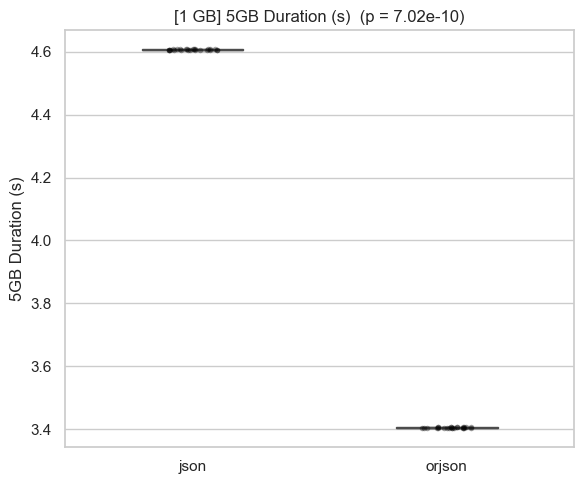

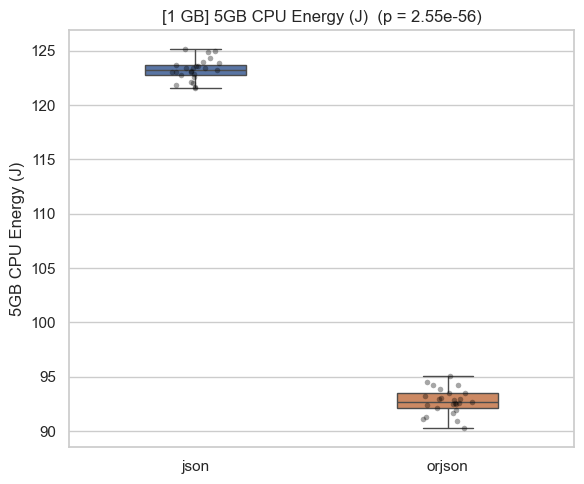

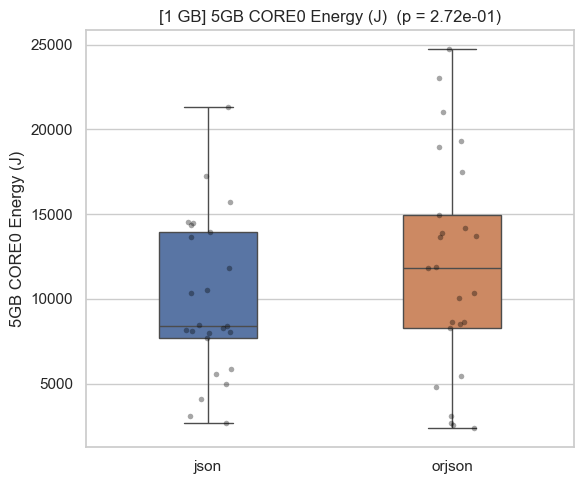

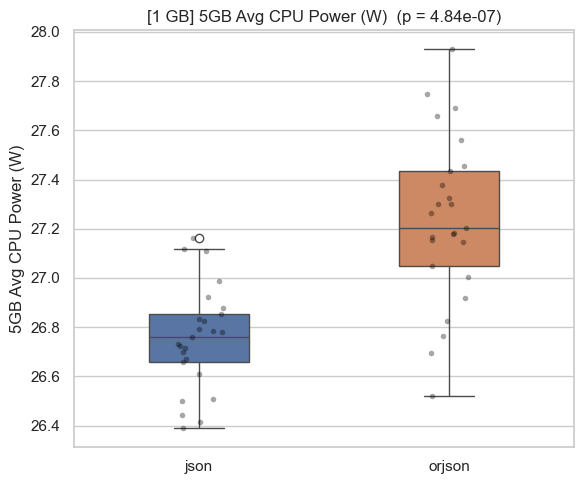

In [48]:
for metric in METRICS:
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.boxplot(data=clean_df_1, x="library", y=metric, hue="library", ax=ax, width=0.4,
                palette={"json": "#4C72B0", "orjson": "#DD8452"}, legend=False)
    sns.stripplot(data=clean_df_1, x="library", y=metric, ax=ax,
                  color="black", alpha=0.35, size=4, jitter=True)
    p = results_1[metric]["p_value"]
    ax.set_title(f"[1 GB] {LABELS[metric]}  (p = {p:.2e})")
    ax.set_xlabel("")
    ax.set_ylabel(LABELS[metric])
    fig.tight_layout()
    fig.savefig(FIGURES / f"1g_{metric}.png", dpi=150, bbox_inches="tight")
    plt.show()

## 11. 1 GB — Energy vs Duration scatter

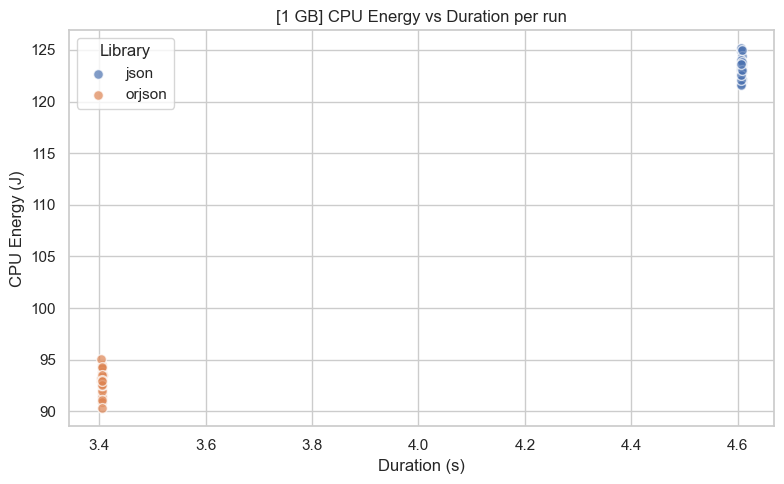

In [49]:
fig, ax = plt.subplots(figsize=(8, 5))
for lib, grp in clean_df_1.groupby("library"):
    ax.scatter(grp["duration_s"], grp["cpu_energy_j"],
               label=lib, color=colors[lib], s=50, alpha=0.7, edgecolors="white")
ax.set_xlabel("Duration (s)")
ax.set_ylabel("CPU Energy (J)")
ax.set_title("[1 GB] CPU Energy vs Duration per run")
ax.legend(title="Library")
fig.tight_layout()
fig.savefig(FIGURES / "1g_energy_vs_duration.png", dpi=150, bbox_inches="tight")
plt.show()

---
## 12. Cross-dataset comparison — Average CPU Power (1 GB vs 5 GB)

Brings together all four groups to compare **average CPU power (W)** and the
other energy metrics side-by-side.  Each group label encodes both the library
and the file size so trends across scale are immediately visible.

| Group | Data source |
|-------|-------------|
| `json · 1 GB` | `json_energy_1g/` after outlier removal |
| `orjson · 1 GB` | `orjson_energy_1g/` after outlier removal |
| `json · 5 GB` | `json_energy/` after outlier removal |
| `orjson · 5 GB` | `orjson_energy/` after outlier removal |

In [50]:

def _tag(df, library, size):
    d = df[df["library"] == library].copy()
    d["group"] = f"{library} · {size}"
    d["size"] = size
    return d

combined = pd.concat([
    _tag(clean_df_1, "json",   "1 GB"),
    _tag(clean_df_1, "orjson", "1 GB"),
    _tag(clean_df,   "json",   "5 GB"),
    _tag(clean_df,   "orjson", "5 GB"),
], ignore_index=True)

GROUP_ORDER = ["json · 1 GB", "orjson · 1 GB", "json · 5 GB", "orjson · 5 GB"]
GROUP_PALETTE = {
    "json · 1 GB":   "#6fa8dc",
    "orjson · 1 GB": "#f6a84e",
    "json · 5 GB":   "#2c5f8a",
    "orjson · 5 GB": "#b85c0a",
}

summary = (
    combined.groupby("group")[METRICS]
    .agg(["mean", "std", "median"])
    .round(4)
)
print("=== Summary statistics across all four groups ===")
print(summary.to_string())
summary

=== Summary statistics across all four groups ===
              duration_s                  cpu_energy_j                    core0_energy_j                         avg_cpu_power_w                 
                    mean     std   median         mean      std    median           mean         std      median            mean     std   median
group                                                                                                                                            
json · 1 GB       4.6071  0.0009   4.6070     123.2651   0.9705  123.2820      9971.7512   4710.2064   8374.8963         26.7553  0.2104  26.7597
json · 5 GB      23.4710  0.4826  23.2395     631.1983  14.1573  627.3958     32796.7993  13770.0592  31038.7670         26.8922  0.1655  26.8774
orjson · 1 GB     3.4053  0.0007   3.4050      92.7406   1.1534   92.6575     11758.1408   6505.1932  11789.9691         27.2341  0.3397  27.2042
orjson · 5 GB    22.2028  0.8748  22.4350     635.6914  23.9769  635.7220 

duration_s                  cpu_energy_j                     \
                    mean     std   median         mean      std    median   
group                                                                       
json · 1 GB       4.6071  0.0009   4.6070     123.2651   0.9705  123.2820   
json · 5 GB      23.4710  0.4826  23.2395     631.1983  14.1573  627.3958   
orjson · 1 GB     3.4053  0.0007   3.4050      92.7406   1.1534   92.6575   
orjson · 5 GB    22.2028  0.8748  22.4350     635.6914  23.9769  635.7220   

              core0_energy_j                         avg_cpu_power_w          \
                        mean         std      median            mean     std   
group                                                                          
json · 1 GB        9971.7512   4710.2064   8374.8963         26.7553  0.2104   
json · 5 GB       32796.7993  13770.0592  31038.7670         26.8922  0.1655   
orjson · 1 GB     11758.1408   6505.1932  11789.9691         27.2341  0.3397   
orjson · 5 GB     55173.6559  10020.1892  56917.7267         28.6377  0.5257   

                        
                median  
group                   
json · 1 GB    26.7597  
json · 5 GB    26.8774  
orjson · 1 GB  27.2042  
orjson · 5 GB  28.4124

C:\Users\andre\AppData\Local\Temp\ipykernel_30824\2076045847.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")


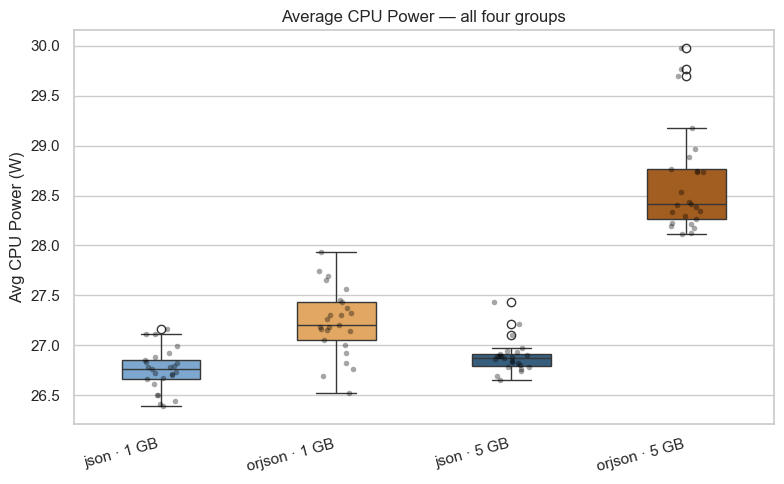

In [51]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(
    data=combined, x="group", y="avg_cpu_power_w",
    order=GROUP_ORDER, hue="group", hue_order=GROUP_ORDER,
    palette=GROUP_PALETTE, width=0.45, ax=ax, legend=False,
)
sns.stripplot(
    data=combined, x="group", y="avg_cpu_power_w",
    order=GROUP_ORDER, ax=ax,
    color="black", alpha=0.35, size=4, jitter=True,
)
ax.set_title("Average CPU Power — all four groups")
ax.set_xlabel("")
ax.set_ylabel("Avg CPU Power (W)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
fig.tight_layout()
fig.savefig(FIGURES / "cross_avg_cpu_power.png", dpi=150, bbox_inches="tight")
plt.show()

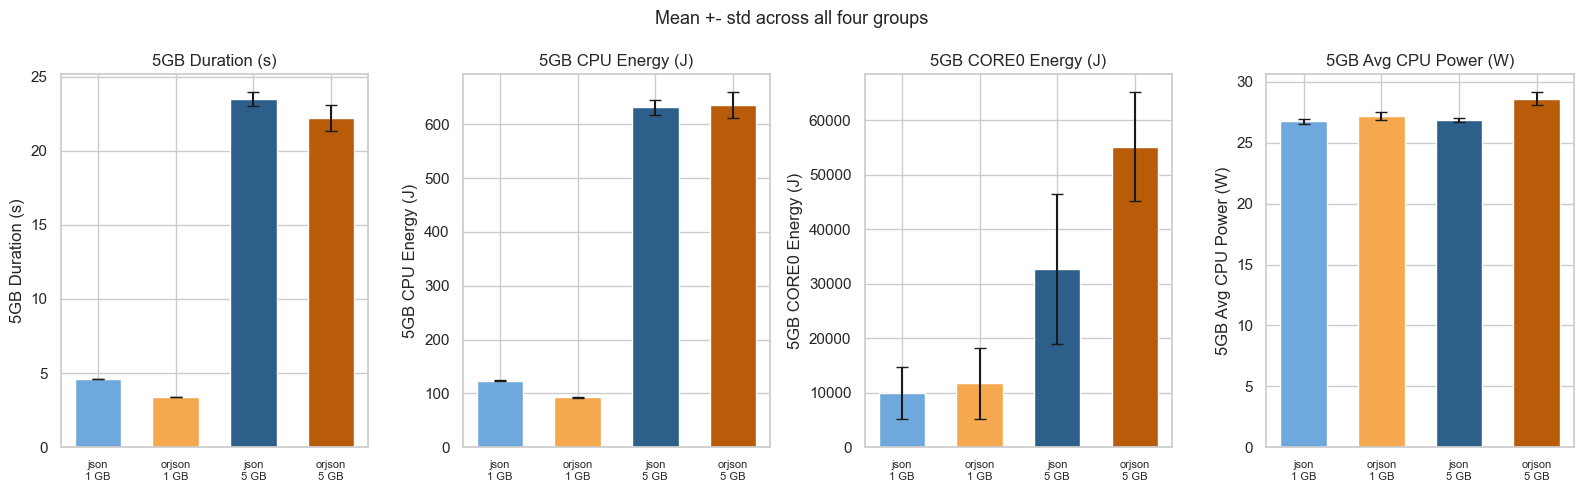

In [52]:
fig, axes = plt.subplots(1, len(METRICS), figsize=(16, 5), sharey=False)
x = range(len(GROUP_ORDER))

for ax, metric in zip(axes, METRICS):
    means = [combined[combined["group"] == g][metric].mean() for g in GROUP_ORDER]
    stds  = [combined[combined["group"] == g][metric].std()  for g in GROUP_ORDER]
    bar_colors = [GROUP_PALETTE[g] for g in GROUP_ORDER]
    ax.bar(x, means, yerr=stds, capsize=4, color=bar_colors, edgecolor="white", width=0.6)
    ax.set_title(LABELS[metric])
    ax.set_xticks(list(x))
    ax.set_xticklabels(
        ["json\n1 GB", "orjson\n1 GB", "json\n5 GB", "orjson\n5 GB"],
        fontsize=8,
    )
    ax.set_ylabel(LABELS[metric])

fig.suptitle("Mean +- std across all four groups", fontsize=13)
fig.tight_layout()
fig.savefig(FIGURES / "cross_all_metrics_bar.png", dpi=150, bbox_inches="tight")
plt.show()